# 네이버 영화 이진분류
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 환경설정

한국어 토크나이저 사용을 위함


In [2]:
%%bash
# Means, that the following code will be executed by bash.

apt-get update
apt-get install g++ openjdk-8 python-dev python3-dev
# 오픈소스로 관리하는 java
pip install JPype1
pip install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

E: Unable to locate package openjdk-8


In [3]:
%env JAVA_HOME = '/user/lib/jvm/java-8-openjdk-amd64'

env: JAVA_HOME='/user/lib/jvm/java-8-openjdk-amd64'


## 데이터 준비

In [4]:
%cd /content

/content


In [5]:
!pmd

/bin/bash: pmd: command not found


In [6]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [7]:
df = pd.read_csv("/content/nsmc/ratings_train.txt", sep='\t')
df.shape

(150000, 3)

In [8]:
df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 결측치 제거

In [9]:
train_data = df.copy()
train_data.count()

id          150000
document    149995
label       150000
dtype: int64

In [10]:
train_data.isna().sum()

id          0
document    5
label       0
dtype: int64

In [11]:
train_data['document'].duplicated().sum()

3817

In [12]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [13]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [14]:
train_data = train_data.dropna()

In [15]:
train_data['document'] = train_data['document'].str.replace('[^가-힣 ]','')
# 한글만 남기고 다 날리기

train_data.head(10)

<ipython-input-15-42e1fd12438d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^가-힣 ]','')


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [16]:
train_data['document'] = train_data['document'].str.replace('^ +','')
# 괄호 있는 상태로 [^] 이면 제외하고 라는 뜻
# 괄호 없이 ^ +이 있으면 스페이스로 글자가 시작됨을 뜻함

train_data['document'] = train_data['document'].replace('', np.nan)
# 특수문자만 들어있는 리뷰들도 없애버리기 위함 (전처리 후 공백이 됨)

train_data = train_data.dropna()

train_data.head()

<ipython-input-16-69f45b686d5d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +','')


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
# test 전처리도 동일하게 진행

(145248, 3)

## 토큰화

In [35]:
from tqdm import tqdm
# 진행도 알 수 있음

from konlpy.tag import Okt

stopwords = ['의', '가', '이', '은', '들', '자', '는', '영화', '에', '을']
okt = Okt()

X_tmp = []
for sentence in tqdm(train_data['document']):
  temp_x = okt.morphs(sentence, stem=True)
  temp_x = [word for word in temp_x if not word in stopwords]
  # 불용어가 아니면 word를 temp_x에 저장
  X_tmp.append(temp_x)

100%|██████████| 145248/145248 [08:18<00:00, 291.24it/s]


In [36]:
X_tmp[:5]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_tmp)

In [40]:
print(tokenizer.word_index)

{'<OOV>': 1, '보다': 2, '하다': 3, '도': 4, '를': 5, '없다': 6, '이다': 7, '있다': 8, '좋다': 9, '너무': 10, '다': 11, '정말': 12, '한': 13, '되다': 14, '재밌다': 15, '적': 16, '만': 17, '같다': 18, '진짜': 19, '으로': 20, '로': 21, '아니다': 22, '않다': 23, '점': 24, '에서': 25, '만들다': 26, '과': 27, '나오다': 28, '연기': 29, '것': 30, '평점': 31, '내': 32, '최고': 33, '그': 34, '나': 35, '안': 36, '인': 37, '스토리': 38, '생각': 39, '못': 40, '왜': 41, '드라마': 42, '게': 43, '감동': 44, '사람': 45, '보고': 46, '이렇다': 47, '말': 48, '고': 49, '아깝다': 50, '더': 51, '배우': 52, '때': 53, '와': 54, '감독': 55, '아': 56, '거': 57, '그냥': 58, '재미있다': 59, '요': 60, '재미': 61, '시간': 62, '내용': 63, '뭐': 64, '까지': 65, '중': 66, '주다': 67, '좀': 68, '자다': 69, '하고': 70, '지루하다': 71, '재미없다': 72, '네': 73, '쓰레기': 74, '수': 75, '모르다': 76, '가다': 77, '들다': 78, '그렇다': 79, '싶다': 80, '지': 81, '작품': 82, '사랑': 83, '알다': 84, '하나': 85, '다시': 86, '마지막': 87, '볼': 88, '잘': 89, '이건': 90, '정도': 91, '저': 92, '완전': 93, '오다': 94, '많다': 95, '처음': 96, '장면': 97, '액션': 98, '주인공': 99, '이렇게': 100, '안되다': 101, '걸': 10

In [41]:
X_train = tokenizer.texts_to_sequences(X_tmp)
X_train[:5]

[[56, 454, 19, 261, 658],
 [929, 456, 46, 601, 216, 1436, 29, 952, 673, 23],
 [385, 2413, 1, 2233, 5617, 2, 224, 13, 11],
 [6425, 109, 7640, 219, 61, 6, 31, 3560],
 [1015,
  19230,
  34,
  9069,
  29,
  827,
  2547,
  25,
  1098,
  242,
  3,
  14110,
  19231,
  1068,
  254,
  242]]

In [42]:
y_train = train_data['label'].values

In [43]:
y_train[:10]

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1])

In [44]:
len(tokenizer.word_index)

43079

In [45]:
drop_train = []

for index, sentence in enumerate(X_train):
  if len(sentence) < 2:
    drop_train.append(index)    # 나중에 지워버릴 인덱스 저장

len(drop_train)

3008

In [46]:
X_train = np.delete(X_train, drop_train, axis=0)

In [47]:
len(X_train)

142240

## padding

In [48]:
review_len = [ len(x) for x in X_train ]

print(review_len)

[5, 10, 9, 8, 16, 15, 5, 38, 6, 14, 7, 13, 16, 17, 23, 5, 24, 13, 16, 14, 13, 5, 43, 7, 5, 12, 5, 3, 10, 17, 8, 6, 7, 5, 6, 10, 8, 6, 6, 3, 22, 5, 10, 28, 8, 40, 16, 5, 48, 15, 12, 11, 13, 2, 28, 3, 7, 7, 8, 27, 10, 44, 26, 13, 10, 9, 6, 36, 7, 4, 15, 7, 2, 17, 3, 10, 4, 16, 5, 3, 4, 2, 3, 5, 6, 5, 6, 2, 7, 4, 8, 2, 6, 5, 12, 16, 9, 8, 7, 4, 14, 3, 8, 9, 9, 13, 7, 15, 2, 4, 4, 11, 3, 30, 15, 8, 3, 2, 6, 6, 14, 40, 9, 2, 4, 3, 9, 7, 9, 13, 5, 13, 14, 10, 43, 2, 4, 4, 35, 21, 11, 46, 9, 10, 4, 2, 3, 19, 9, 5, 6, 12, 5, 34, 48, 11, 2, 13, 9, 27, 37, 6, 5, 4, 13, 2, 3, 12, 6, 35, 6, 36, 4, 13, 4, 6, 27, 8, 3, 13, 11, 17, 16, 12, 4, 16, 9, 24, 8, 11, 6, 50, 13, 6, 11, 3, 13, 5, 3, 7, 6, 11, 3, 11, 10, 8, 11, 9, 26, 7, 18, 11, 4, 12, 5, 6, 24, 10, 28, 10, 43, 43, 6, 4, 9, 15, 9, 8, 8, 9, 11, 11, 13, 8, 9, 4, 5, 7, 12, 3, 5, 2, 9, 7, 8, 3, 11, 5, 23, 5, 15, 12, 5, 3, 29, 9, 7, 5, 6, 3, 6, 5, 15, 16, 2, 11, 31, 9, 14, 31, 7, 4, 15, 2, 22, 9, 39, 3, 10, 32, 4, 22, 5, 4, 16, 14, 28, 7, 5, 10, 14

<function matplotlib.pyplot.show(*args, **kw)>

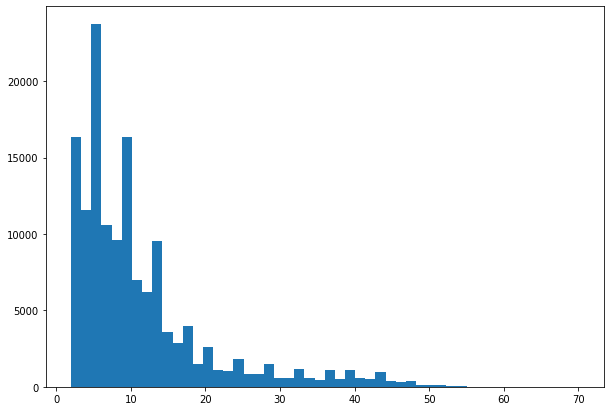

In [49]:
plt.figure(figsize=(10,7))
plt.hist(review_len, bins=50)
plt.show

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=200, padding='pre')
X_train[:10]

array([[   0,    0,    0, ...,   19,  261,  658],
       [   0,    0,    0, ...,  952,  673,   23],
       [   0,    0,    0, ...,  224,   13,   11],
       ...,
       [   0,    0,    0, ...,  703, 1062,   73],
       [   0,    0,    0, ...,    8,  366,  101],
       [   0,    0,    0, ...,   10, 5619,    8]], dtype=int32)

## 모델

In [51]:
X_train.shape

(142240, 200)

In [67]:
model = keras.Sequential([
    layers.Embedding(20000, 16, input_length=30),
    layers.LSTM(128, activation='tanh'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

EPOCHS = 15
BATCH_SIZE = 32

In [69]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 16)            320000    
                                                                 
 lstm_6 (LSTM)               (None, 128)               74240     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In [59]:
X_train.shape

(142240, 200)

In [62]:
y_train = np.delete(y_train, drop_train, axis=0)
y_train.shape

(142240,)

In [68]:
log = model.fit(X_train, y_train,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                validation_split = 0.2,
                verbose = 1)

Epoch 1/15


ValueError: ignored

In [53]:
def predict_review(review):
  sentence = okt.morphs(review, stem=True)                          # 토큰화
  sentence = [word for word in sentence if not word in stopwords]   # 불용어 제거
  sentence = tokenizer.texts_to_sequences([sentence])               # 정수 인코딩
  sentence = pad_sequences(sentence, maxlen=30)                     # 패딩
  score = float(model.predict(sentence))                            # 예측
  if score > 0.5:
    print(f"{score:2.f}% 긍정")
  else:
    print(f"{score:2.f}% 부정")

In [54]:
predict_review("솔직히 말하자면 처음에 영화 제목을 들었을때 난 고개를 갸우뚱했다")

1/1 [==============================] - 5s 5s/step


ValueError: ignored